# Conducting linear regression in python

In [81]:
import sklearn
from sklearn.datasets import load_boston
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess

import OLS_Rplots

In [2]:
boston = load_boston()
boston_df = pd.DataFrame(boston.data)
boston_df.columns = boston['feature_names']
boston_df['MEDV'] = boston['target']
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## Data Set Characteristics
(Taken from boston['DESCR'])
- CRIM:     per capita crime rate by town        
- ZN:       proportion of residential land zoned for lots over 25,000 sq.ft.        
- INDUS:    proportion of non-retail business acres per town        
- CHAS:     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)        
- NOX:      nitric oxides concentration (parts per 10 million)        
- RM:       average number of rooms per dwelling        
- AGE:      proportion of owner-occupied units built prior tproo 1940        
- DIS:      weighted distances to five Boston employment centres       
- RAD:      index of accessibility to radial highways        
- TAX:      full-value property-tax rate per \$10,000
- PTRATIO:  pupil-teacher ratio by town       
- B:        1000(Bk - 0.63)^2 where Bk is the proportion of [African-Americans] by town
- LSTAT:    lower status of the population        
- MEDV:     Median value of owner-occupied homes in \$1000's

## Conducting the regression

In [3]:
model = smf.ols(formula='MEDV ~ CRIM + CHAS + ZN', data=boston_df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     59.67
Date:                Mon, 18 Nov 2019   Prob (F-statistic):           5.23e-33
Time:                        15:04:00   Log-Likelihood:                -1763.1
No. Observations:                 506   AIC:                             3534.
Df Residuals:                     502   BIC:                             3551.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.9715      0.449     48.937      0.0

# Making the plots in an R OLS
1. Residuals vs. Fitted
2. Normal QQ plot
3. Scale - Location Plot
4. Residuals vs. Leverage

### 1. Residuals vs. Fitted

In [73]:
residuals = results.resid
fitted = results.fittedvalues
smoothed = lowess(residuals,fitted)

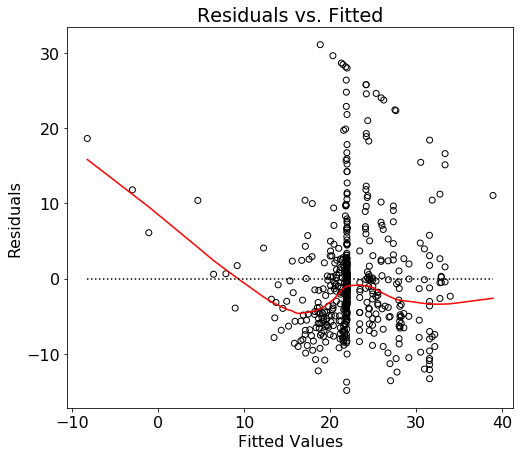

In [74]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (8,7)
fig, ax = plt.subplots()
ax.scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted Values')
ax.set_title('Residuals vs. Fitted')
ax.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':')


plt.show()

## 2. Normal QQ Plot

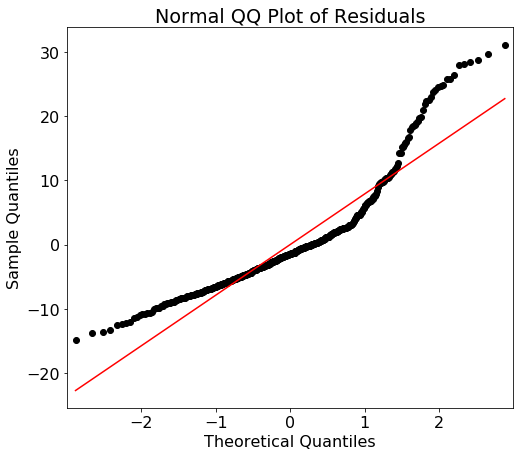

In [11]:
#default is a standard normal distribution
#line = 's' plots the line after standardizing for mean and standard deviation of the samples
fig, ax = plt.subplots()
sm.qqplot(residuals, line = 's', ax = ax, color = 'k')
ax.set_title('Normal QQ Plot of Residuals')
plt.show()

## 3. Scale - location plot

In [64]:
#calculate studentized residuals
norm_residuals = results.get_influence().resid_studentized_internal
sqrt_norm_residuals = np.sqrt(np.abs(norm_residuals))
smoothed = lowess(sqrt_norm_residuals,fitted)

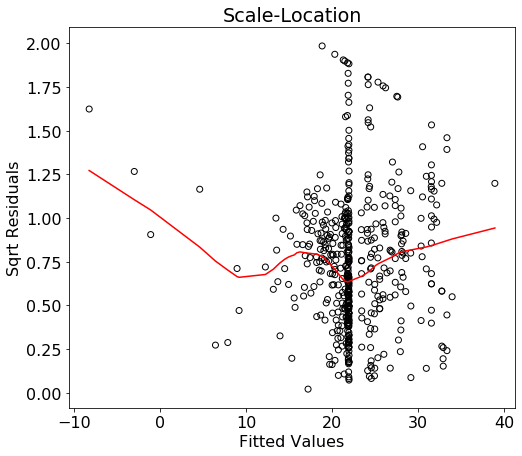

In [65]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (8,7)
fig, ax = plt.subplots()
ax.scatter(fitted, sqrt_norm_residuals, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('Sqrt Residuals')
ax.set_xlabel('Fitted Values')
ax.set_title('Scale-Location')
plt.show()

## 4. Residuals vs. Leverage

In [55]:
leverage = results.get_influence().hat_matrix_diag
smoothed = lowess(norm_residuals,leverage)

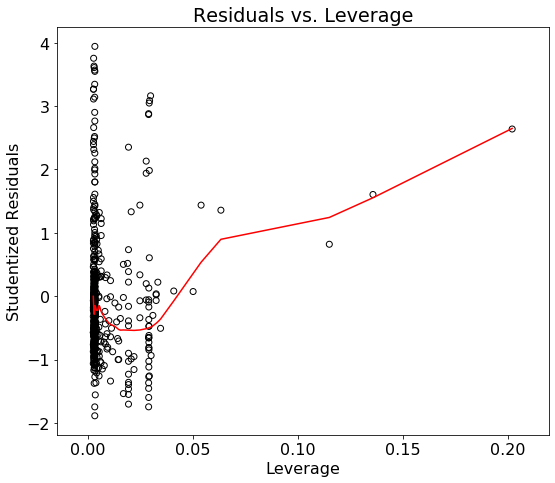

In [56]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (8,7)
#Ok so let's plot the average purchase behavior of each price category by channel and by year
fig, ax = plt.subplots()
ax.scatter(leverage, norm_residuals, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('Studentized Residuals')
ax.set_xlabel('Leverage')
ax.set_title('Residuals vs. Leverage')

# Save the figure and show
plt.tight_layout()
#plt.savefig('Category1SpendingAllClust.png', dpi = 300, bbox_inches = 'tight')
plt.show()